### Import libraries

In [125]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Predefined functions

In [126]:
def cvShow(image, name):
    cv.imshow(name, image)
    cv.waitKey(0)
    cv.destroyAllWindows()


def pltShow(img, name):
    plt.title(name)
    plt.imshow(img)
    plt.show()


def resize(image, width=None, height=None, inter=cv.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height/float(h)
        dim = (int(w*r), height)
    else:
        r = width/float(w)
        dim = (width, int(h*r))
    resized = cv.resize(image, dim, interpolation=inter)
    return resized

def printMaxtirx(matrix):
    for row in matrix:
        print(row)
    print(' ')

### Customized variables

In [215]:
MAZE_FILE_NAME = '../Maze.png'
ROBOT_FILE_NAME = '../Robot.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
TXT_FILE_NAME = '../MapBuilt.txt'

MAZE_IMAGE_WIDTH = 1350
MAZE_IMAGE_HEIGHT = 750
ROBOT_IMAGE_WIDTH = 750
ROBOT_IMAGE_HEIGHT = 750

LIGHT_GREEN = [50, 240, 120]
LIGHT_PINK = [230, 130, 235]
LIGHT_BLUE = [130, 240, 240]
LIGHT_YELLOW = [255, 71, 25]
ORANGE = [255, 255, 75]
BLACK = [0, 0, 0]
WHITE = [255, 255, 255]
GREEN = [30, 220, 40]
BLUE = [0, 0, 255]
GOOD_YELLOW = [235, 225, 35]

NORTH = 0
SOUTH = 1
WEST = 2
EAST = 3

kernal9 = np.ones((9, 9), "uint8")
kernal7 = np.ones((7, 7), "uint8")
kernal5 = np.ones((5, 5), "uint8")
kernal3 = np.ones((3, 3), "uint8")
kernal1 = np.ones((1, 1), "uint8")

pink_lower = np.array([125, 200, 220])
pink_upper = np.array([175, 255, 255])

cyan_lower = np.array([80, 120, 220])
cyan_upper = np.array([100, 140, 255])

wall_lower = np.array([17, 40, 215])
wall_upper = np.array([22, 125, 255])

robot_lower = np.array([30, 0, 140])
robot_upper = np.array([120, 175, 200])

### Pre-process

In [216]:
maze = cv.imread(MAZE_FILE_NAME)
robot = cv.imread(ROBOT_FILE_NAME)
ladybug = cv.imread(IMAGE_LADYBUG_FILE_NAME)
maze = resize(maze, width=MAZE_IMAGE_WIDTH, height=MAZE_IMAGE_HEIGHT)
maze_hsv = cv.cvtColor(maze, cv.COLOR_BGR2HSV)

# 3.1. Read in an image and display it in RGB mode

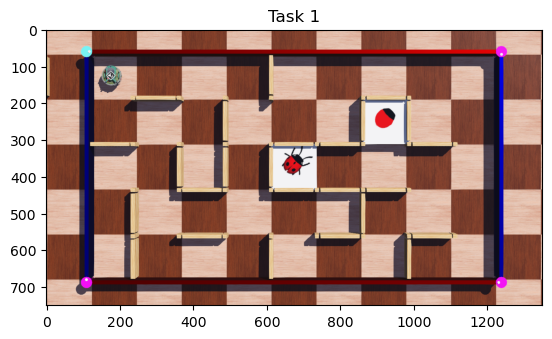

In [217]:
maze_rgb = cv.cvtColor(maze, cv.COLOR_BGR2RGB)
pltShow(maze_rgb, 'Task 1')

# 3.2. Find the four ordered cornerstones of the maze

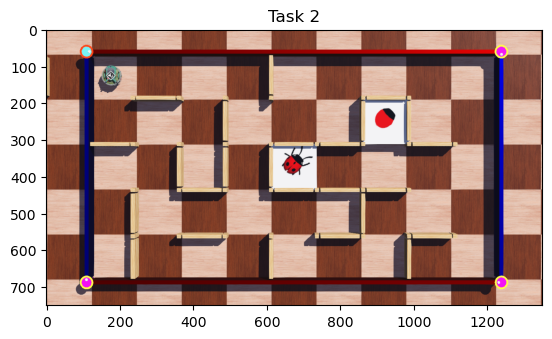

In [218]:
maze2 = maze_rgb.copy()

# To find cyan(key)conerstones

cyan_mask = cv.inRange(maze_hsv, cyan_lower, cyan_upper)

cyan_mask = cv.dilate(cyan_mask, kernal3, iterations=1)

# pltShow(cyan_mask, 'cyan mask')

img,cyanContours, cyanHierarchy = cv.findContours(
    cyan_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cyanContours = sorted(cyanContours, key=cv.contourArea, reverse=True)[:1]

if len(cyanContours) != 0:
    for contour in cyanContours:
        if cv.contourArea(contour) > 200:
            cv.ellipse(maze2, cv.fitEllipse(contour), LIGHT_YELLOW, 3)
            x, y, w, h = cv.boundingRect(contour)
            x_cord = int((x+x+w)/2)
            y_cord = int((y+y+h)/2)
            key_center = (x_cord, y_cord)

# To find pink cornerstones

pink_mask = cv.inRange(maze_hsv, pink_lower, pink_upper)

pink_mask = cv.dilate(pink_mask, kernal3, iterations=1)

# pltShow(pink_mask, 'pink mask')

img, pinkContours, pinkHierarchy = cv.findContours(
    pink_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

pinkContours = sorted(pinkContours, key=cv.contourArea, reverse=True)[:3]
if len(pinkContours) != 0:
    for contour in pinkContours:
        if cv.contourArea(contour) > 200:
            cv.ellipse(maze2, cv.fitEllipse(contour), ORANGE, 3)

pltShow(maze2, 'Task 2')

# 3.3. Perspective transform the maze from the original image to a rectangle image


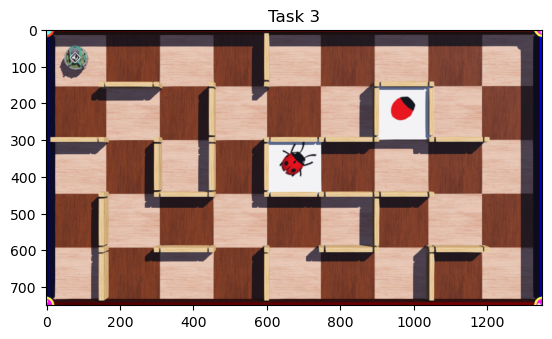

In [219]:
maze3 = maze2.copy()

center_record = {}

for c in pinkContours:
    x, y, w, h = cv.boundingRect(c)
    x_cord = int((x+x+w)/2)
    y_cord = int((y+y+h)/2)
    center = (x_cord, y_cord)
    if (key_center[0] > 0 and key_center[0] < 337.5 and key_center[1] > 0 and key_center[1] < 375):

        if (x_cord > 0 and x_cord < 337.5 and y_cord > 375 and y_cord < 750):
            center_record[1] = center
        elif (x_cord > 1012.5 and x_cord < 1350 and y_cord > 0 and y_cord < 375):
            center_record[0] = center
        else:
            center_record[2] = center
    elif (key_center[0] > 1012.5 and key_center[0] < 1350 and key_center[1] > 375 and key_center[1] < 750):
        if (x_cord > 1012.5 and x_cord < 1350 and y_cord > 0 and y_cord < 375):
            center_record[1] = center
        elif (x_cord > 0 and x_cord < 337.5 and y_cord > 375 and y_cord < 750):
            center_record[0] = center
        else:
            center_record[2] = center
    else:
        print('Original image rotated too mcuh！！！')

pts1 = np.float32([key_center, center_record[0], center_record[1], center_record[2]])
pts2 = np.float32([[0, 0], [MAZE_IMAGE_WIDTH, 0], [0, MAZE_IMAGE_HEIGHT], [MAZE_IMAGE_WIDTH, MAZE_IMAGE_HEIGHT]])
matrix = cv.getPerspectiveTransform(pts1, pts2)
maze3 = cv.warpPerspective(
    maze3, matrix, (MAZE_IMAGE_WIDTH, MAZE_IMAGE_HEIGHT))

robot = cv.copyMakeBorder(robot, 0, 0, 300, 300, cv.BORDER_CONSTANT)
# cvShow(robot, 'nonTransfered Robot')
robot = cv.warpPerspective(
    robot, matrix, (MAZE_IMAGE_WIDTH, MAZE_IMAGE_HEIGHT))

pltShow(maze3, 'Task 3')

# 3.4 Detect all the internal walls

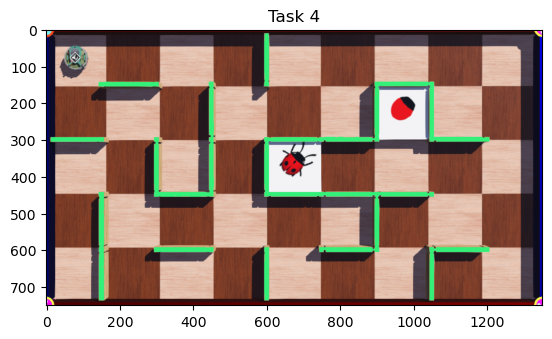

In [220]:
maze4 = maze3.copy()
maze_hsv = cv.cvtColor(maze4, cv.COLOR_RGB2HSV)
wall_mask = cv.inRange(maze_hsv, wall_lower, wall_upper)
# cvShow(wall_mask, 'Wall mask')
wall_mask = cv.morphologyEx(wall_mask, cv.MORPH_CLOSE, kernal7, iterations=1)
# cvShow(wall_mask, 'After close')
wall_mask = cv.erode(wall_mask, kernal3, iterations=2)
# cvShow(wall_mask, 'After erosion')
wall_mask = cv.dilate(wall_mask, kernal3, iterations=2)
# cvShow(wall_mask, 'After dilation')


wall_mask = 255-wall_mask
maze4 = cv.bitwise_and(maze4, maze4, mask=wall_mask)
Rmask = np.all(maze4 == BLACK,  axis=-1)
maze4[Rmask] = LIGHT_GREEN
wall_mask = 255-wall_mask

pltShow(maze4, 'Task 4')

# 3.5 Detection the location and heading of the robot

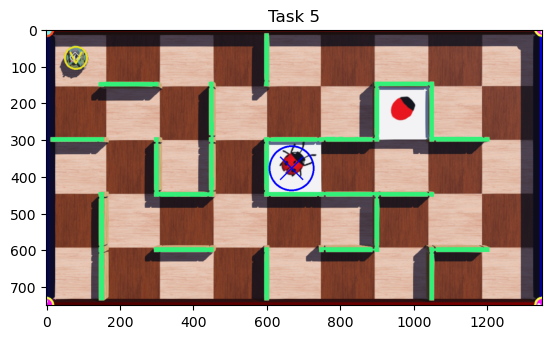

In [221]:
maze5 = maze4.copy()

dictionary = cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250)

robot_bgr = robot.copy()
# robot_rgb_origin = cv.cvtColor(robot_bgr, cv.COLOR_BGR2RGB)
robot_rgb = cv.cvtColor(robot_bgr, cv.COLOR_BGR2RGB)

parameters = cv.aruco.DetectorParameters_create()

markerCorners, markerIds, rejectedCandidates = cv.aruco.detectMarkers(
    robot_rgb, dictionary, parameters=parameters)

robot_rgb = cv.aruco.drawDetectedMarkers(robot_rgb, markerCorners, markerIds)

acceptBias = 20.0
# print(markerCorners)
if (abs(markerCorners[0][0][0][1] - markerCorners[0][0][2][1]) < acceptBias and markerCorners[0][0][0][0] < markerCorners[0][0][2][0]):
    direction = WEST
#     print('west!')
elif (abs(markerCorners[0][0][0][1] - markerCorners[0][0][2][1]) < acceptBias and markerCorners[0][0][0][0] > markerCorners[0][0][2][0]):
    direction = EAST
#     print('east!')
elif (abs(markerCorners[0][0][0][0] - markerCorners[0][0][2][0]) < acceptBias and markerCorners[0][0][0][1] < markerCorners[0][0][2][1]):
    direction = NORTH
#     print('north!')
elif (abs(markerCorners[0][0][0][0] - markerCorners[0][0][2][0]) < acceptBias and markerCorners[0][0][0][1] > markerCorners[0][0][2][1]):
    direction = SOUTH
#     print('south!')
else:
    print('Ops! I cant recognize the direction')
    # print(markerCorners[0][0][0][0], markerCorners[0]
    #       [0][2][0], markerCorners[0][0][0][0], markerCorners[0][0][2][0])

maze_hsv = cv.cvtColor(maze5.copy(), cv.COLOR_RGB2HSV)
robot_mask = cv.inRange(maze_hsv, robot_lower, robot_upper)


robot_mask = cv.erode(robot_mask, kernal3, iterations=1)
# cvShow(robot_mask, 'robot mask')
robot_mask = cv.morphologyEx(robot_mask, cv.MORPH_CLOSE, kernal7, iterations=7)
# robot_mask = cv.erode(robot_mask, kernal1, iterations=5)
robot_mask = cv.dilate(robot_mask, kernal3, iterations=3)
# cvShow(robot_mask, 'robot mask')


_, robotContours, robotHierarchy = cv.findContours(
    robot_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# robotContours = sorted(robotContours, key=cv.contourArea, reverse=True)[:1]
robotContours = max(robotContours, key=cv.contourArea)
x, y, w, h = cv.boundingRect(robotContours)
row, col = np.where(robot_mask > 0)
robot_center = (int(x+w/2), int(y+h/2))
# print(robot_center)
robot_radius = 30
maze5 = cv.circle(maze5, robot_center, robot_radius, GOOD_YELLOW, 3)



length = 15
if direction == NORTH:
    point1 = (robot_center[0], robot_center[1]-length)
    point2 = (robot_center[0]-length, robot_center[1]+length)
    point3 = (robot_center[0]+length, robot_center[1]+length)
elif direction == SOUTH:
    point1 = (robot_center[0], robot_center[1]+length)
    point2 = (robot_center[0]-length, robot_center[1]-length)
    point3 = (robot_center[0]+length, robot_center[1]-length)
elif direction == WEST:
    point1 = (robot_center[0]-length, robot_center[1])
    point2 = (robot_center[0]+length, robot_center[1]-length)
    point3 = (robot_center[0]+length, robot_center[1]+length)
elif direction == EAST:
    point1 = (robot_center[0]+length, robot_center[1])
    point2 = (robot_center[0]-length, robot_center[1]-length)
    point3 = (robot_center[0]-length, robot_center[1]+length)

maze5 = cv.line(maze5, point1, point2, GOOD_YELLOW, 3)
maze5 = cv.line(maze5, point1, point3, GOOD_YELLOW, 3)

# Detect the position for true target
template = ladybug.copy()
w, h = template.shape[:-1]

# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
img = maze5.copy()
method = cv.TM_CCOEFF

res = cv.matchTemplate(img, template, method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc

bottom_right = (top_left[0] + w, top_left[1] + h)

ladybug_center = (int(top_left[0]+w/2), int(top_left[1]+h/2))

# Draw oulter circle
ladybug_radius = 60
cv.circle(maze5, ladybug_center, ladybug_radius, BLUE, 3)

# Drae cross sign
length = 30
point1 = (ladybug_center[0]-length, ladybug_center[1]-length)
point2 = (ladybug_center[0]+length, ladybug_center[1]-length)
point3 = (ladybug_center[0]+length, ladybug_center[1]+length)
point4 = (ladybug_center[0]-length, ladybug_center[1]+length)

cv.line(maze5, point1, point3, BLUE, 4)
cv.line(maze5, point2, point4, BLUE, 4)

pltShow(maze5, 'Task 5')

# 3.6 Generate the map

 --- --- --- --- --- --- --- --- ---

| v             |                   |   

     ---                 ---        

|           |           |   |       |   

 ---             --- ---     ---    

|       |   |   | x                 |   

         ---     --- --- ---        

|   |                   |           |   

         ---         ---     ---    

|   |           |           |       |   

 --- --- --- --- --- --- --- --- ---



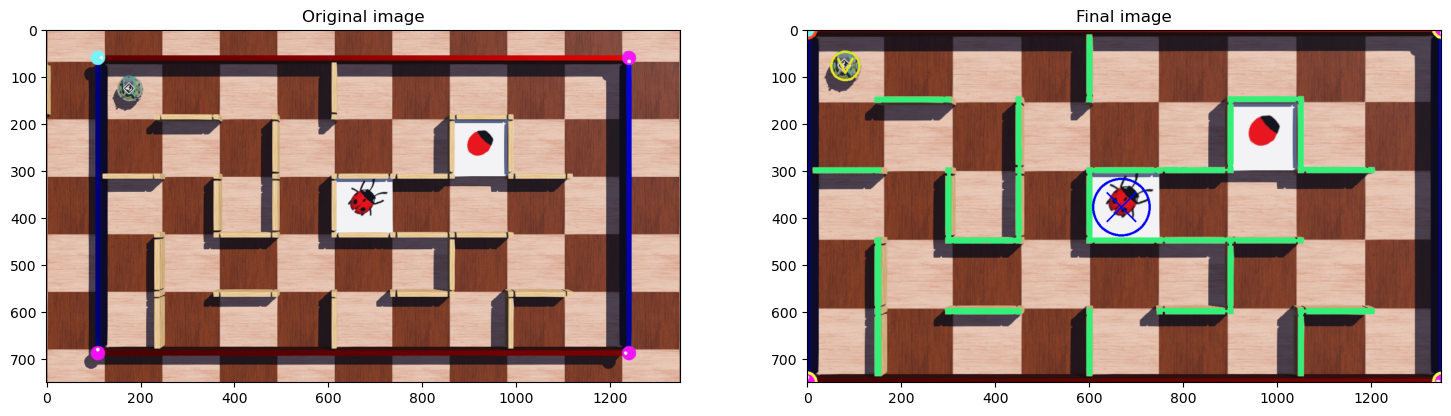

In [222]:
# initialize the vertical wall matrix
rows, cols = (5, 10)
virtical_wall = np.zeros((5, 10))

# initialize the horizontal wall matrix
rows, cols = (6, 9)
horizontal_wall = np.zeros((6, 9))

wall_mask = cv.dilate(wall_mask,kernal3,1)
# cvShow(wall_mask,'Dilated wall mask')

bias = 10
for i, row in enumerate(virtical_wall):

    for j, val in enumerate(row):
        if (j == 0 or j == 9):
            row[j] = 1

        elif (wall_mask[150*i+75][150*j] == 255 or wall_mask[150*i+75+bias][150*j] or wall_mask[150*i+75-bias][150*j]):
            row[j] = 1

for i, row in enumerate(horizontal_wall):

    for j, val in enumerate(row):
        if (i == 0 or i == 5):
            row[j] = 1

        elif (wall_mask[150*i][150*j+75] or wall_mask[150*i][150*j+75+bias] or wall_mask[150*i][150*j+75-bias]):
            row[j] = 1

robot_coordinate = (
    round((robot_center[1]-75)/150), round((robot_center[0]-75)/150))
ladybug_coordinate = (
    round((ladybug_center[1]-75)/150), round((ladybug_center[0]-75)/150))

map = open(TXT_FILE_NAME, 'w', encoding="utf-8")

# print(horizontal_wall[0][:])
message = []
for i in range(11):
    newMessage = []
    # record horizontal wall:
    if (i % 2 == 0):

        for val in horizontal_wall[int(i / 2)]:

            newMessage.append(' ')
            if (val == 1):
                newMessage.append('---')

            else:
                newMessage.append('   ')

    # record vertical wall:
    else:
        colCounter = 0
        for val in virtical_wall[int((i-1) / 2)]:

            if (val == 1):
                newMessage.append('|')
            else:
                newMessage.append(' ')

            if(int((i-1) / 2) == ladybug_coordinate[0] and colCounter == ladybug_coordinate[1]):
                newMessage.append(' x ')
            elif(int((i-1) / 2) == robot_coordinate[0] and colCounter == robot_coordinate[1]):
                if (direction == NORTH):
                    newMessage.append(' ^ ')
                elif (direction == SOUTH):
                    newMessage.append(' v ')
                elif (direction == EAST):
                    newMessage.append(' > ')
                elif (direction == WEST):
                    newMessage.append(' < ')
            else:
                newMessage.append('   ')

            colCounter += 1
    message.append(newMessage)

for content in message:
    str = ''
    for elements in content:
        str += elements
    str += '\n'
    map.write(str)
    print(str)

map.close()


fig, (ax1, ax2) = plt.subplots(figsize=(18, 10), ncols=2)
ax1.imshow(maze_rgb)
ax2.imshow(maze5)
ax1.set_title('Original image')
ax2.set_title('Final image')
plt.show()